# Projet Python pour le Data Scientist 

## Analyse des tendances musicales

### THÉLOT Léonard
### TITA Nadir 

Introduction 

Étant tous les deux amateurs de musique, nous avons décidé de nous tourner vers un sujet portant sur la prédiction des genres musicaux.

Notre idée initiale était de prédire les futures tendances musicales en France. Après avoir scrappé les Top 100 en France des dernières années et effectué des statistiques descriptives dessus, nous nous sommes rendus compte que les caractéristiques des musiques présentes dans ces top n’avaient quasiment pas évolué au cours du temps. On a alors estimé que faire des prédictions la dessus n’était pas des plus pertinent. Pour vérifier si cette régularité était propre à la France, nous avons fait la même chose sur le top 100 aux USA et constaté la même chose.  

Nous avons donc du réorienter notre idée première. Tout d’abord nous avons vérifié à l’aide de statistiques descriptives que les features musicaux dans les bases que nous avions scrappé étaient pertinent, principalement graphiquement. 

Ensuite, nous avons pu effectuer nos premiers modèles de prédiction sur deux genres musicaux avec en fusionnant des playlists spotify. Nous avons appliqué et optimisé les hyperparamètres d’une random forest et avons obtenu des score plutôt satisfaisant (90%).

Afin de poursuivre notre démarche, nous avons tenté de généraliser notre prédiction à 6 genres musicaux avec une nouvelle base scrappée. Là encore, nous avons appliqué et optimiser les hyperparamètres d’une random Forrest et d’une régression logistique mais aussi d’un gradient boosting et d’un k-NN.
Ces quatre algorithmes ont été choisi pour recouvrir différentes structures d’algorithmes de machine learning : la géométrie vectorielle avec les SVM, les arbres de décision indépendant pour la random Forrest, une régression permettant de donner une probabilité à chaque output potentiel pour la régression logistique et la recherche des k plus proche voisins pour le k-NN. Ce dernier a obtenu des scores très médiocres mais c’est sûrement dû à la faible quantité de données que nous avions.

Par ailleurs, nous avons aussi tenté de faire de la classification non supervisée en utlisant une base de données obtenu en scrappant les artistes qui sont venus à l'émission TV Taratata pour couvrir un large panel de genres musicaux, mais l'impossibilité d'évaluer nos résultats nous a bloqué, d'autant plus que nous pouvions plus échanger avec notre chargé de TD cette dernière semaine. 

Importation des modules nécessaires

In [1]:
import bdd
import fonctions as fct

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import scipy.stats as st
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA

from sklearn import svm

# I. Importation des différentes bases de données

Dans ce projet, nous n'avons utilisé aucunes bases de données existantes.
Nous avons utilisé des techniques de scrapping sur différents sites couplés à l'utilisation de l'API de spotify afin d'obtenir les données dont nous avions besoin au fur et à mesure du développement du sujet et des nouvelles idées que nous apportions.

On peut trouver le code dans le fichier bdd.py

### a. Top 100 des ventes en France depuis 2000

Source : SNEP

In [3]:
top100fr = bdd.playlist_top100fr()

pourcentage de données manquantes : 12.428571428571429 %
0


### b. Top 100 des ventes aux États-Unis depuis 2000

Source : Billboard

In [4]:
top100us = bdd.playlist_top100us()

pourcentage de données manquantes : 7.010014306151645 %
0


### c. Playlist labelisé rnb et rock

Source : playlist spotify 

In [2]:
rnbrock = bdd.playlist_rnbrock()

0


### d. Playlist labelisé rock, jazz, funk, classique, rap français et rnb

Source : playlist spotify

In [2]:
divers = bdd.playlist_6clusters()

0


# II. Statistiques descriptives

   ##     1. Analyse du Top 100 FR

### Observation du Dataset

In [7]:
top100fr.head()

,Artiste,Titre,Année,Rang,id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,baquet g sargue d d'avilla p,les rois du monde (romeo juliette),2000,2,2QxpVhguEv67Lwlf3wwltb,52,0.747,0.729,8,-4.766,1,0.0285,0.168,0.000000,0.2170,0.866,115.084,205440,4
2,d sargue p d'avilla g baquet,les rois du monde (romeo juliette),2001,75,2QxpVhguEv67Lwlf3wwltb,52,0.747,0.729,8,-4.766,1,0.0285,0.168,0.000000,0.2170,0.866,115.084,205440,4
4,levi daniel,l'envie d'aimer (les dix commandements),2000,4,0TNGfsGVd73QadekqZs3VG,53,0.425,0.665,11,-7.892,1,0.0335,0.196,0.000011,0.1050,0.136,134.327,388680,4
6,daniel levi,l'envie d'aimer (les dix commandements),2001,77,0TNGfsGVd73QadekqZs3VG,53,0.425,0.665,11,-7.892,1,0.0335,0.196,0.000011,0.1050,0.136,134.327,388680,4
8,anastacia,i'm outta love,2000,6,583xVl0Sbj93uU4ceixgU8,65,0.761,0.716,10,-5.800,0,0.0560,0.398,0.000000,0.0771,0.649,119.406,245400,4


In [34]:
top100fr.columns

Index(['Artiste', 'Titre', 'Année', 'Rang', 'id', 'popularity', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')

- Valence : describes the musical positiveness conveyed by a track. 
- Loudness : physical resonance to sound pressure and intensity, sounds to the ear.
- Liveness : refers directly to reverberation time, ie resonance. 
- Speechniness : detects the presence of spoken words.
- Acousticness : a confidence measure from 0.0 to 1.0 of whether the track is acoustic.

source : free music dictionnary

In [20]:
print(f"La durée moyenne d'une musique est {round((top100fr['duration_ms'] / 60000).mean(),2)} minutes.")

La durée moyenne d'une musique est 3.7 minutes.


### Données manquantes 

Text(0.5, 0, 'Année')

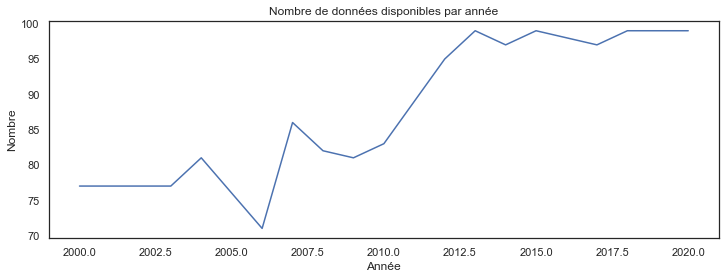

In [50]:
plt.figure(figsize=(12, 4))
sns.set(style="white")
x = top100fr.groupby("Année")["id"].count()
ax = sns.lineplot(x.index,x)
ax.set_title('Nombre de données disponibles par année')
ax.set_ylabel('Nombre')
ax.set_xlabel('Année')

### Artistes les plus présents

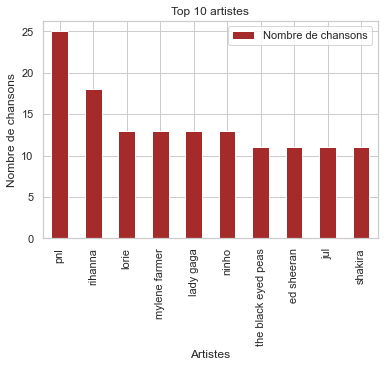

In [38]:
Top10 = pd.DataFrame({'Nombre de chansons':top100fr['Artiste'].value_counts().head(10)})
Top10.plot.bar(color='brown')
plt.title('Top 10 artistes')
plt.xlabel('Artistes')
plt.ylabel('Nombre de chansons')
plt.show()

### Distribution et corrélation des variables

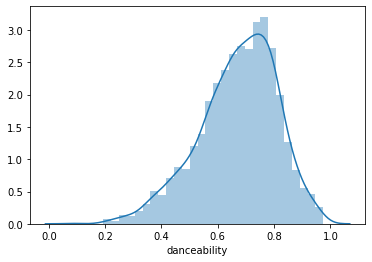

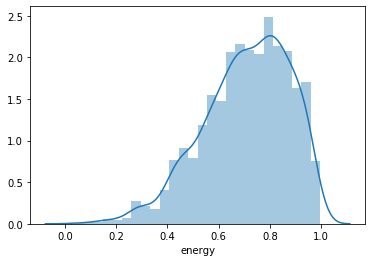

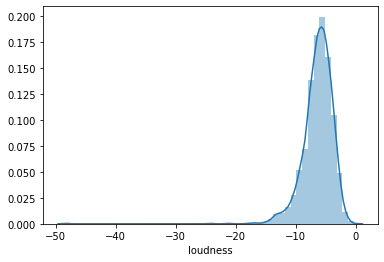

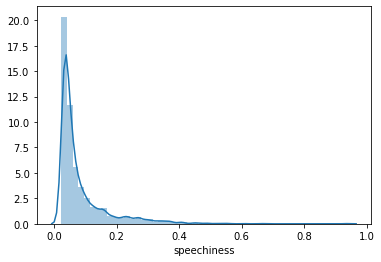

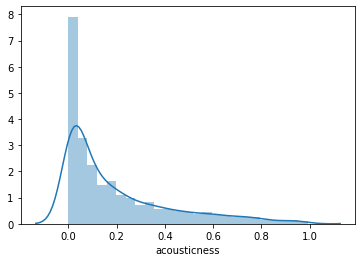

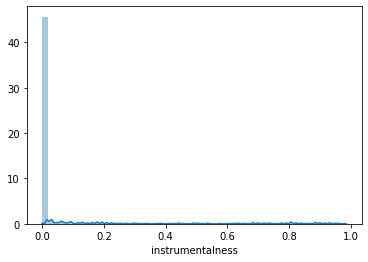

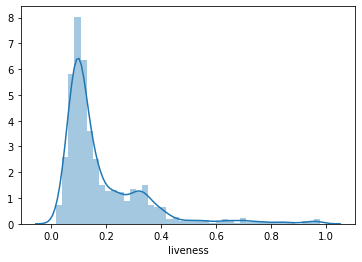

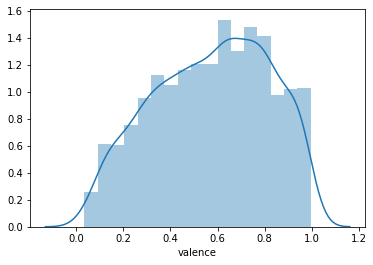

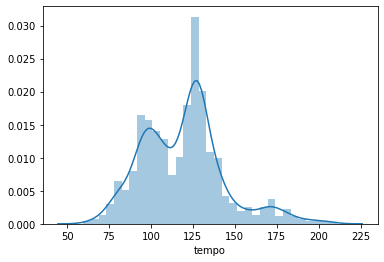

In [7]:
for col in df.select_dtypes('float'):
    plt.figure()
    sns.distplot(df[col])

In [80]:
data = top100fr.drop(["Artiste","Titre","id", "instrumentalness"],axis=1)

<AxesSubplot:>

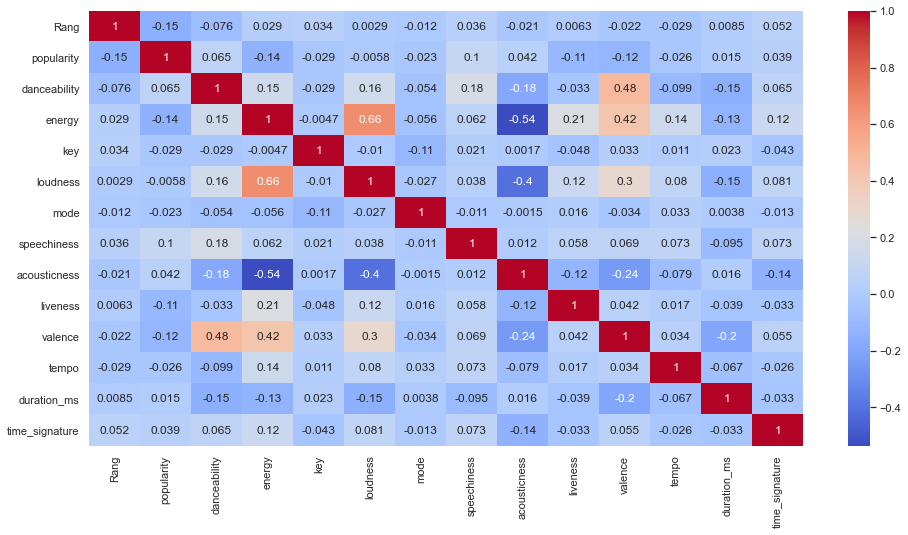

In [31]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = data.corr()
sns.heatmap(corr,annot=True,cmap="coolwarm")

On repère des features fortement corrélés : la valence avec la danceability et l'energy, la loudness et l'energy, l'acousticness et l'energy. 

### Graphiques de l'évolution moyenne des features dans le temps

Text(0.5, 0, 'Année')

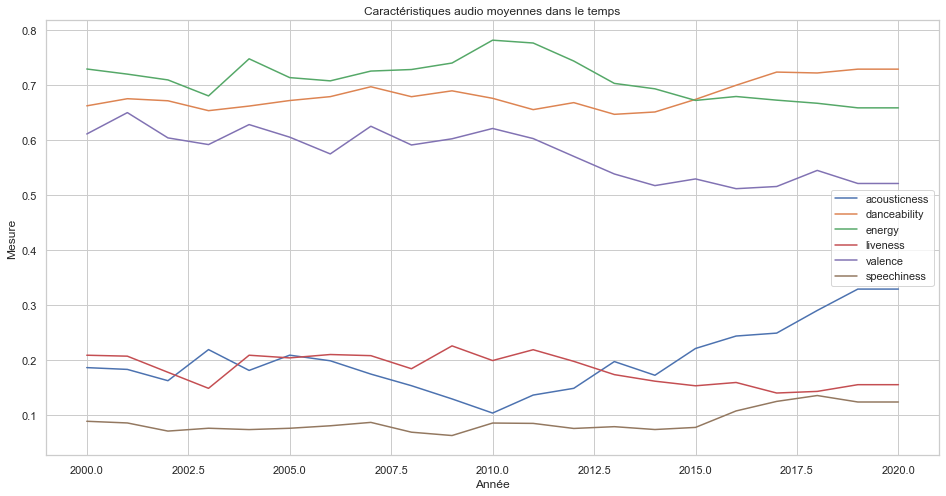

In [81]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
columns = ["acousticness","danceability","energy","liveness","valence","speechiness"]
for col in columns:
    x = data.groupby("Année")[col].mean()
    ax= sns.lineplot(x=x.index,y=x,label=col)
ax.set_title('Caractéristiques audio moyennes dans le temps')
ax.set_ylabel('Mesure')
ax.set_xlabel('Année')

La moyenne de chaque caractéristique est stable : pas de tendances assez fortes pour pour changer tout un top 100 significativement. 

On regarde si il n'y a pas de tendances plus significatives dans le top 10

### Graphiques de l'évolution des features dans le temps du top 10

Text(0.5, 0, 'Année')

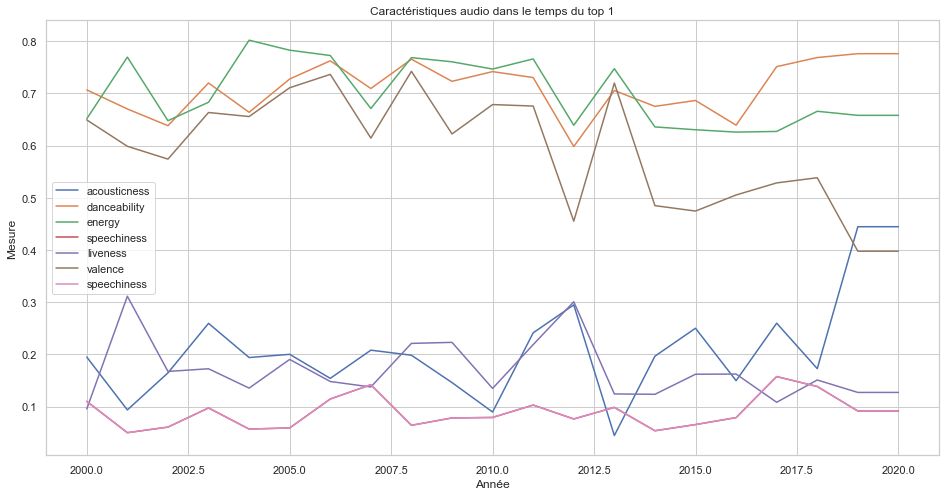

In [94]:
plt.figure(figsize=(16, 8))
dtest= data[data["Rang"] < 11]
sns.set(style="whitegrid")
columns = ["acousticness","danceability","energy","speechiness","liveness","valence","speechiness"]
for col in columns:
    x = dtest.groupby("Année")[col].mean()
    ax= sns.lineplot(x=x.index,y=x,label=col)
ax.set_title('Caractéristiques audio dans le temps du top 1')
ax.set_ylabel('Mesure')
ax.set_xlabel('Année')

Tendance principale : baisse de la valence et augmentation symétrique de l'acousticness.

## 2. Analyse du top 100 US

### Observation du Dataset

In [76]:
top100us.head()

,Artiste,Titre,Année,Rang,id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,daniel powter,bad day,2006,1,0mUyMawtxj1CJ76kn9gIZK,76,0.599,0.785,3,-4.013,1,0.0309,0.448,0.003360,0.1510,0.520,140.046,233640,4
1,sean paul,temperature,2006,2,0k2GOhqsrxDTAbFFSdNJjT,77,0.951,0.600,0,-4.675,0,0.0685,0.106,0.000000,0.0712,0.822,125.040,218573,4
2,nelly furtado ring timbaland,promiscuous,2006,3,47aQT2aV12TyilaoYi1NiD,73,0.795,0.978,10,-6.097,0,0.0459,0.046,0.000083,0.1430,0.843,114.321,242200,4
3,james blunt,you're beautiful,2006,4,0vg4WnUWvze6pBOJDTq99k,77,0.675,0.479,0,-9.870,0,0.0278,0.633,0.000018,0.0880,0.454,81.998,209493,4
4,shakira ring wyclef jean,hips don't lie,2006,5,3ZFTkvIE7kyPt6Nu3PEa7V,83,0.778,0.824,10,-5.892,0,0.0712,0.284,0.000000,0.4050,0.756,100.024,218093,4


In [77]:
top100us.dtypes.value_counts()

float64    9
int64      7
object     3
dtype: int64

### Données manquantes

Text(0.5, 0, 'Année')

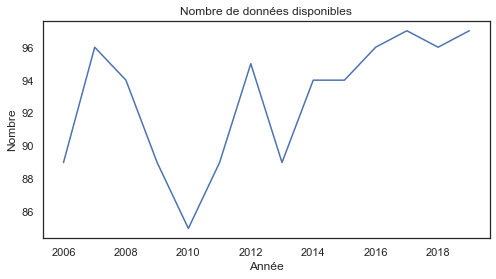

In [101]:
plt.figure(figsize=(8, 4))
sns.set(style="white")
x = top100us.groupby("Année")["id"].count()
ax= sns.lineplot(x.index,x)
ax.set_title('Nombre de données disponibles')
ax.set_ylabel('Nombre')
ax.set_xlabel('Année')

### Top 10 des artistes les plus présents dans le top 100 US

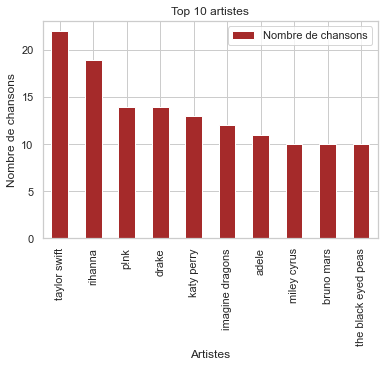

In [99]:
Top10 = pd.DataFrame({'Nombre de chansons':top100us['Artiste'].value_counts().head(10)})
Top10.plot.bar(color='brown')
plt.title('Top 10 artistes')
plt.xlabel('Artistes')
plt.ylabel('Nombre de chansons')
plt.show()

### Corrélation des variables

In [102]:
usb = top100us.drop(["Artiste","Titre","id", "instrumentalness"],axis=1)

<AxesSubplot:>

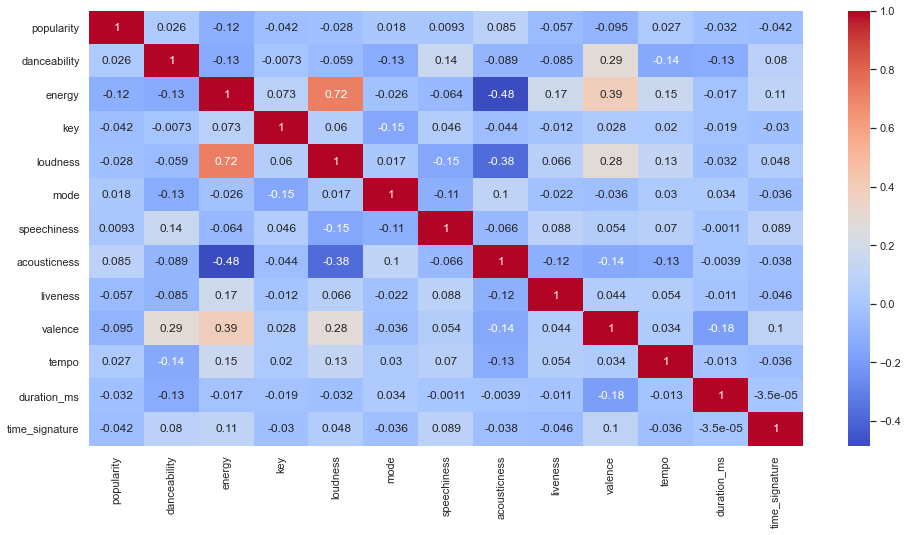

In [103]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = usb.drop(["Année", "Rang"], axis = 1).corr()
sns.heatmap(corr,annot=True,cmap="coolwarm")

On repère des features fortement corrélés : la valence avec la danceability, l'energy et la loudness, la loudness et l'energy, l'acousticness avec l'energy et la loudness -> similaire à la France

### Graphiques de l'évolution des features dans le temps du top 100 puis du top 10

Text(0.5, 0, 'Année')

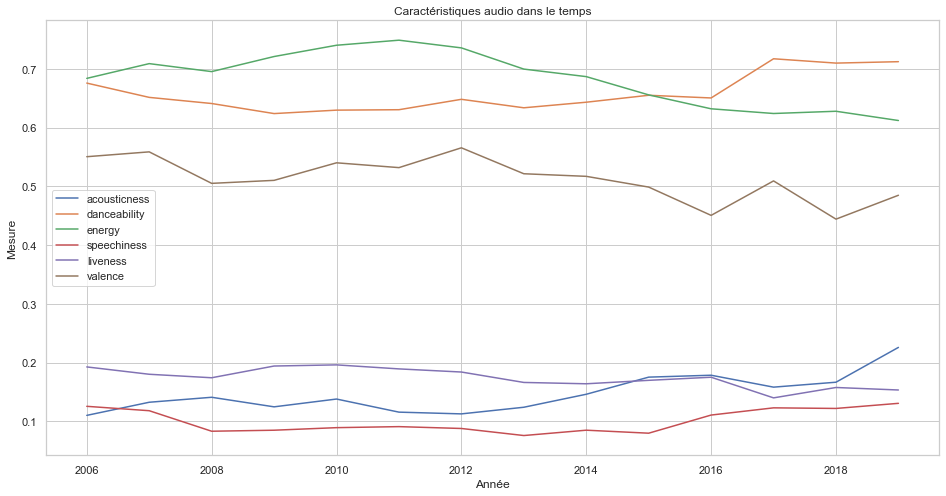

In [104]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
columns = ["acousticness","danceability","energy","speechiness","liveness","valence"]
for col in columns:
    x = usb.groupby("Année")[col].mean()
    ax= sns.lineplot(x=x.index,y=x,label=col)
ax.set_title('Caractéristiques audio dans le temps')
ax.set_ylabel('Mesure')
ax.set_xlabel('Année')

Text(0.5, 0, 'Année')

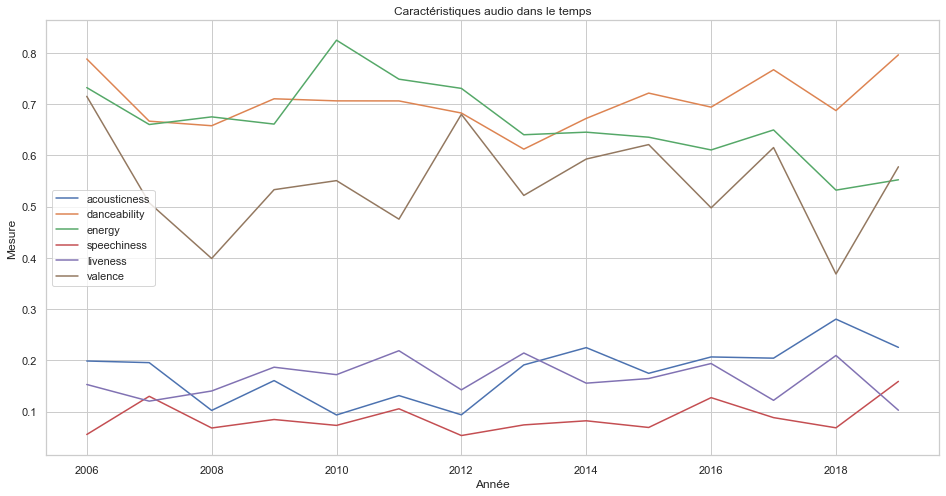

In [109]:
plt.figure(figsize=(16, 8))
dtest=usb[usb["Rang"]<11]
sns.set(style="whitegrid")
columns = ["acousticness","danceability","energy","speechiness","liveness","valence"]
for col in columns:
    x = dtest.groupby("Année")[col].mean()
    ax= sns.lineplot(x=x.index,y=x,label=col)
ax.set_title('Caractéristiques audio dans le temps')
ax.set_ylabel('Mesure')
ax.set_xlabel('Année')

On remarque une baisse tendancielle de l'energy. Sinon pas de tendance marquée même dans un échantillon réduit ! Caractérise une certaine "recette" des musiques populaires. 

## 3. Comparaison des caractéristiques selon le courant musical

In [114]:
divers.sample(6)

,Artiste,Titre,Catégorie,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
247,Marlena Shaw,California Soul,funk,0lNvrXhFOCbHXmxNLGIC7q,0.513,0.8260,8,-8.407,0,0.0574,0.555000,0.000035,0.3660,0.5390,94.582,177227,4
1009,Johann Sebastian Bach Omario Baggeman Jean Ba...,"Prelude and Fugue in C major, BWV 846 ""Das woh...",classique,6yZjW6jJmpUnrRhYqRWB3O,0.196,0.0214,1,-33.554,1,0.0435,0.992000,0.874000,0.0971,0.0845,125.186,142663,4
969,Nothing,Famine Asylum,rock,5918U5xYBF6Dx6T36fwxlw,0.362,0.8960,6,-4.556,1,0.0563,0.000034,0.885000,0.1110,0.2480,175.934,250096,4
337,Oliver Nelson,Stolen Moments,jazz,4ow1XH4hwe3yOGXG2eTTTY,0.575,0.1870,0,-13.081,0,0.0513,0.927000,0.876000,0.1660,0.3420,107.469,525613,4
1071,Johann Pachelbel Music Lab Collective Valenti...,"Canon in D Major, P.37",classique,6A6vSsLkXoTJZ8cA4vtznl,0.404,0.1250,2,-17.933,1,0.0434,0.988000,0.937000,0.1130,0.2270,106.399,288853,4
831,The Rolling Stones,Wild Horses - 2009 Mix,rock,52dm9op3rbfAkc1LGXgipW,0.432,0.3890,7,-6.517,1,0.0255,0.687000,0.010700,0.0788,0.1580,139.506,341773,4


In [110]:
divers["Catégorie"].value_counts()

jazz         305
classique    284
funk         268
rock         244
rap_fr       243
rnb          237
Name: Catégorie, dtype: int64

In [17]:
divers = divers.drop(["Artiste","Titre","id"],axis=1)

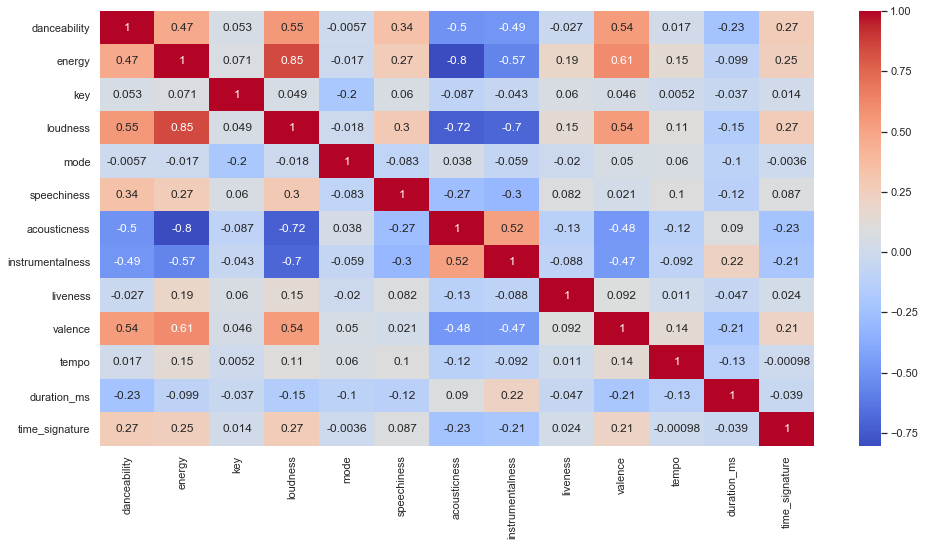

In [11]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = vrac.corr()
sns.heatmap(corr,annot=True,cmap="coolwarm")

### Comparaison de la distribution de chaque genre musical selon chaque feature

In [40]:
jazz = divers[divers["Catégorie"]=="jazz"]
country = divers[divers["Catégorie"]=="country"]
funk = divers[divers["Catégorie"]=="funk"]
rock = divers[divers["Catégorie"]=="rock"]
rap_fr =divers[divers["Catégorie"]=="rap_fr"]
drill = divers[divers["Catégorie"]=="drill"]
classique = divers[divers["Catégorie"]=="classique"]
rnb = divers[divers["Catégorie"]=="rnb"]

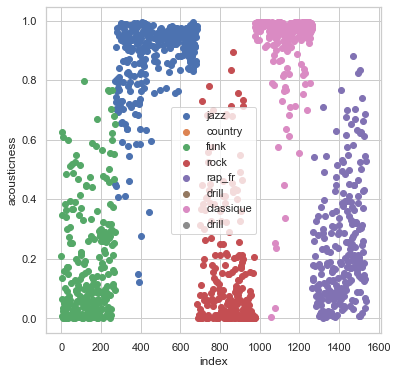

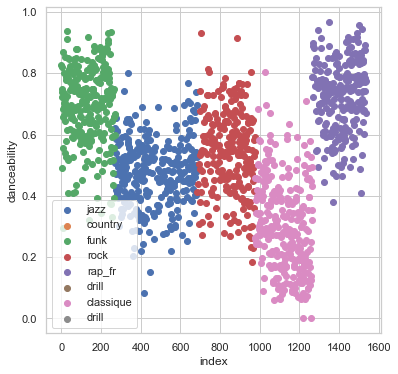

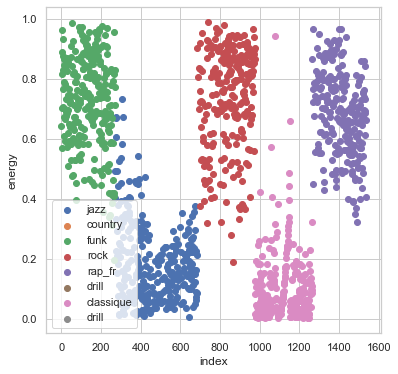

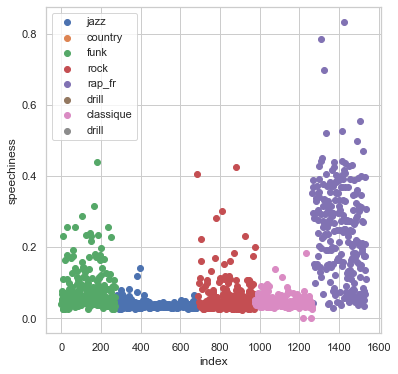

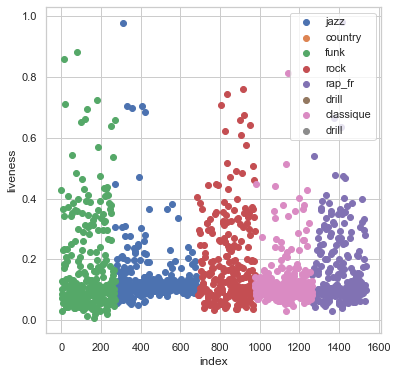

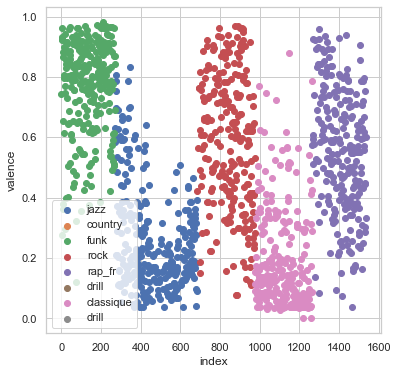

In [143]:
for feature in ["acousticness","danceability","energy","speechiness","liveness","valence"]: 
    fig, ax = plt.subplots(figsize = (6, 6))

    columns = ["jazz","country","funk","rock","rap_fr","drill","classique","drill"]
    for col in columns:
        x = divers[divers["Catégorie"]==col][feature]
        ax.scatter(x.index, x,label=col)

    plt.ylabel(feature)
    plt.xlabel("index")
    plt.legend()

# III. Modèles de prédictions

## 1.Classification binaire

Étudions par exemple deux styles musicaux qui semblent opposés : le rnb et le rock

In [7]:
rnbrock.sample(6)

,Artiste,Titre,Catégorie,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
464,Drake,Marvins Room,rnb,047fCsbO4NdmwCBn8pcUXl,0.492,0.260,9,-17.341,0,0.0921,0.646000,0.001780,0.0705,0.312,111.519,347227,5
569,Jhené Aiko,Triggered (freestyle),rnb,3PAptX72PPmjj1Igms0zjo,0.471,0.411,0,-9.500,1,0.2950,0.810000,0.000000,0.1350,0.363,89.484,211227,1
533,Drake,Passionfruit,rnb,5mCPDVBb16L4XQwDdbRUpz,0.809,0.463,11,-11.377,1,0.0396,0.256000,0.085000,0.1090,0.364,111.980,298941,4
1194,Kip Macklejar,The Coal Miner's Daughter,rock,7F1oldudpxoyl5nKRqTugV,0.458,0.653,9,-7.911,0,0.0311,0.000083,0.000091,0.2520,0.569,85.045,236160,4
1188,Run The Jewels Royal Blood,the ground below (feat. Royal Blood) - Royal J...,rock,0ZihFuThMaeARjmxTsoNFe,0.594,0.867,7,-6.637,1,0.2000,0.005260,0.000008,0.2930,0.531,90.062,173132,4
1378,Mötley Crüe,Home Sweet Home,rock,4zXvB4MoQD8onk0NCZbeHG,0.403,0.777,5,-6.416,1,0.0354,0.099900,0.000003,0.1240,0.149,76.329,240933,4


### a. Méthode 1 : Linear SVM avec 2 features

'score sur test set: 0.8873239436619719'

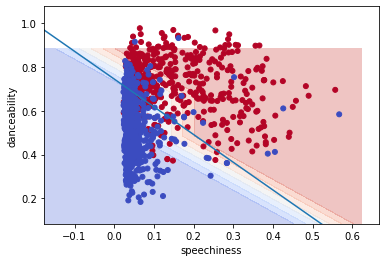

In [4]:
fct.plot_best_hypp(rnbrock, 'rnb', 'rock')

### b. Méthode 2 : Random Forest Classifier

In [8]:
X=rnbrock.drop(['Catégorie','Artiste', 'Titre', 'id'],axis=1)
y=rnbrock['Catégorie']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

Sans tuning

In [5]:
rf= RandomForestClassifier()

In [6]:
rf.fit(X_train, y_train)
rf.score(X_test,y_test)

0.9061032863849765

Avec tuning et une liste d'hyperparamètres à tester : 

In [6]:
fct.rf_grid(X_train,y_train, X_test, y_test)

Fitting 4 folds for each of 192 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed:  2.1min finished


Score final :  87.7934  %
Meilleurs parametres:  {'bootstrap': True, 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 100}


Tuning avec hyperparamètres random

In [8]:
fct.rf_rdgrid(X_train,y_train, X_test, y_test, n_iter = 50)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.0min finished


Score final :  91.0798  %
Meilleurs parametres:  {'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}


## 2. Classification avec six genres musicaux

On utilise la base de données "divers" déjà utilisée. 

In [9]:
divers.sample(6)

,Artiste,Titre,Catégorie,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
1771,Mase Total,What You Want (feat. Total),rnb,2nqVVwUI2MJ7MaphpCF1P3,0.8800,0.7260,10,-5.855,0,0.2570,0.0218,0.000077,0.3890,0.8230,93.814,271213,4
1418,Diam's,Marine - Version 2006,rap_fr,4m8WJ3qra5m7WlBYaEqqxB,0.6820,0.7360,2,-5.605,1,0.3930,0.1430,0.000000,0.4740,0.4700,84.067,340800,4
240,Al Green,Tired Of Being Alone,funk,6d9rNfRFOQ0XmsUwJ8C5J0,0.7730,0.4180,7,-7.645,1,0.0423,0.5030,0.000086,0.0893,0.7150,98.324,163160,4
806,Aerosmith,Walk This Way,rock,2vX5WL7s6UdeQyweZEx7PP,0.6290,0.7850,5,-10.761,1,0.0471,0.0249,0.000009,0.0522,0.8690,108.531,211027,4
1174,Johann Sebastian Bach Orpheus Chamber Orchestra,"Suite No.3 In D Major, BWV 1068: 2. Air",classique,5C3ngUFpuVNNv2gSmLvJTR,0.0855,0.1740,2,-20.636,1,0.0424,0.9320,0.764000,0.1540,0.0763,65.503,280826,3
1041,Frédéric Chopin Danica Binx Gerard Tahaud,"Preludes in B Minor, Op.28: XI. Prelude",classique,6br3CZxAs0ehQYJHDEFpSW,0.5370,0.0554,7,-28.796,1,0.0762,0.9950,0.966000,0.0933,0.3460,95.780,99935,4


In [3]:
y=divers['Catégorie']
X=divers.drop(['Artiste', 'Titre', 'Catégorie', 'id'],axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

### a. SVM 

Malheureusement, la projection sur deux axes avec 6 catégories devient compliquée

In [4]:
model = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo')

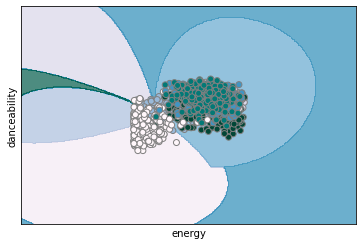

'score sur test set: 0.49842271293375395'

In [5]:
fct.plot_SVM(divers, model)

### b. kNN 

Sans tuning

In [4]:
knn=KNeighborsClassifier()
knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.1861198738170347

Avec tuning

In [5]:
fct.knn_grid(X_train,y_train, X_test, y_test)

Fitting 4 folds for each of 550 candidates, totalling 2200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 516 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1328 tasks      | elapsed:   14.8s


Score final :  19.5584  %
Meilleurs parametres:  {'leaf_size': 1, 'n_neighbors': 8, 'p': 1}


[Parallel(n_jobs=-1)]: Done 2200 out of 2200 | elapsed:   22.2s finished


### c. Random Forest

Sans tuning

In [6]:
rf_clust= RandomForestClassifier()
rf_clust.fit(X_train, y_train)
rf_clust.score(X_test,y_test)

0.7539432176656151

Avec tuning

In [7]:
fct.rf_grid(X_train,y_train, X_test, y_test)

Fitting 4 folds for each of 192 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed:  2.2min finished


Score final :  74.1325  %
Meilleurs parametres:  {'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 100}


Avec tuning randomisé

In [8]:
fct.rf_rdgrid(X_train,y_train, X_test, y_test, n_iter = 100)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  6.5min finished


Score final :  76.9716  %
Meilleurs parametres:  {'n_estimators': 1500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}


### d. Régression logistique

Sans tuning 

In [9]:
log = LogisticRegression()
log.fit(X_train,y_train)
log.score(X_test,y_test)

0.21766561514195584

Avec tuning 

In [10]:
fct.rl_grid(X_train,y_train, X_test, y_test)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  5.5min finished


Score final :  73.1861  %
Meilleurs parametres:  {'C': 0.5, 'max_iter': 300, 'penalty': 'none', 'solver': 'newton-cg'}
